# Data preprocessing and feature extraction

In this series, we will embark with preparing the raw dataset by loading the reviews from a set of text documents (each file contains separate review). Because in the era of deep learning the more training data the better, we will merge data provided by IMDb into one dataset, which will enable us to use different proportions of splitting into training/validation/test sets. Then we will be extracting some additional text features from our dataset so that they could be used to increase the accuracy of our prediction model. New features will be depicted on plots in order to increase readability, and help us to draw proper conclusions whether extracted features are relevant. Then we will perform text preprocessing that includes among the others: removing HTML tags, lemmatization, making text lower case or disposing of stopwords. In the end, we will split the entire dataset into training, validation and test sets. 

Before we delve into the coding part, let me introduce to you the subject of our interest and one of the most important parts of Natural Language Processing - sentiment analysis and its influence on the market.

## 1. Define the problem

### 1.1. Business problem

Sentiment analysis (also referred to as an opinion mining) is a process of identifying, extracting and quantifying emotions from the written language. Sentiment Analysis can be modelled as a text classification task, which tries to solve the problem of labelling the polarity of a given text at the document, whether the opinion is positive, negative (or neutral). This technique is very significant for companies because it allows them to understand what consumers or clients think about their products, services or brand. Nowadays, the prevalent use of social networking services like Facebook or Twitter provide an immense amount of information each day. By using sentiment analysis in social media we can gain an insight into the level of satisfaction with a given brand or discern some trends that can be helpful to figure out the way to improve the product or the service quality. Extracted pieces of information from text data about subjective opinions then can be stored in a structured form that will be useful for marketing analysis or product reviews. 

Sentiment analysis is widely applied to:
- Market research and analysis
- Voice of the customer 
- Voice of the employee
- Brand monitoring
- Social media monitoring

### 1.2. Analysis objectives

The objectives of the analysis are the following:
- Extract additional text features and examine the significance of these features for our model's predictive ability. The following are the text features that will be analysed: polarity, subjectivity, word count, Part-Of-Speech tags ratio, uppercase words ratio, digits ratio.
- Preprocess the text data to bring it into the analyzable and interpretable format.
- Build and compare the performance of several machine learning models based on different architectures (covered in next notebooks)

## 2. Feature extraction, Exploratory Data Analysis and text normalization

We will begin with importing all indispensable libraries that will be used in this notebook.

### Importing required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import scattertext as st
import collections
from IPython.display import HTML, IFrame
from textblob import TextBlob
from w3lib.html import remove_tags
from wordcloud import WordCloud
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

### Data loading

We are using IMDb Movie Reviews Dataset for binary sentiment classification that provides a set of 25,000 highly polar reviews for training, and 25,000 for testing (each set contains an equal number of positive and negative examples). As has been mentioned we are going to merge training and testing examples into one dataset. This operation will enable us to use different proportions of splitting into training/validation/test sets (for example 80/10/10) than original ratio provided by IMDb.

Dataset folder structure is as follows:

dataset/<br>
├── test/<br>
│&ensp;&ensp;&ensp;&ensp;  ├── positive/<br>
│&ensp;&ensp;&ensp;&ensp; ├── negative/ <br>
├── train/<br>
  &ensp;&ensp;&ensp;&ensp;&ensp;   ├── positive/<br>
  &ensp;&ensp;&ensp;&ensp;&ensp;  └── negative/<br>


In [ ]:
def load_data(path, file_list, dataset, encoding='utf8'):
    """Read set of files from given directory and save returned lines to list.
    
    Parameters
    ----------
    path : str
        Absolute or relative path to given file (or set of files).
    file_list: list
        List of files names to read.
    dataset: list
        List that stores read lines.
    encoding: str, optional (default='utf8')
        File encoding.
        
    """
    for file in file_list:
        with open(os.path.join(path, file), 'r', encoding=encoding) as text:
            dataset.append(text.read())

According to the dataset structure, we are going to save read lines in four lists (*train_pos, train_neg, test_pos, test_neg*), these correspond to the source directory and set type.

In [63]:
# Path to dataset location
path = 'dataset/'

# Create lists that will contain read lines
train_pos, train_neg, test_pos, test_neg = [], [], [], []

# Create a dictionary of paths and lists that store lines (key: value = path: list)
sets_dict = {'train/positive/': train_pos, 'train/negative/': train_neg,
             'test/positive/': test_pos, 'test/negative/': test_neg}

# Load the data
for dataset in sets_dict:
        file_list = [f for f in os.listdir(os.path.join(path, dataset)) if f.endswith('.txt')]
        load_data(os.path.join(path, dataset), file_list, sets_dict[dataset])

After reading the data we are going to convert populated lists to the pandas dataframe format, assign a label to each of our frames (1 corresponds to positive class, 0 corresponds to negative class), and concatenate vertically (axis=0) all frames into one dataset.

In [64]:
# Concatenate training and testing examples into one dataset
dataset = pd.concat([pd.DataFrame({'review': train_pos, 'label':1}),
                     pd.DataFrame({'review': test_pos, 'label':1}),
                     pd.DataFrame({'review': train_neg, 'label':0}),
                     pd.DataFrame({'review': test_neg, 'label':0})],
                     axis=0, ignore_index=True)

Now we are able to see for the first time how our dataset looks like.

Let's inspect the first and last 5 rows from the dataset.

In [65]:
# Inspect the first 5 rows from dataset
dataset.head()

,review,label
0,Richard Willaims is an animation god. He was h...,1
1,well i was a teenager when i saw the movie..th...,1
2,"***SPOILERS*** ***SPOILERS*** Well, seeing as ...",1
3,There is no doubt that Halloween is by far one...,1
4,Tony Hawk Underground came at a point where th...,1


In [66]:
# Inspect the last 5 rows from dataset
dataset.tail()

,review,label
49995,SILVER CITY (2+ outta 5 stars) As a huge fan o...,0
49996,Four young grade-school girls witness the murd...,0
49997,This sequel to the above - and the final entry...,0
49998,Sad to say this is one of the sillier of John ...,0
49999,"""The Cave"" got released more or less simultane...",0


We can see that we have as expected 50,000 examples (indices from 0 to 49,999).

Now let's check out if the amount of positive examples (label 1) equals the number of examples from negative class (label 0).

In [67]:
# Count the number of examples in each class
dataset.label.value_counts()

1    25000
0    25000
Name: label, dtype: int64

Using df.describe() method we can print the basic information about our data frame. As we can see, the *review* column comprised of 50,000 non-null object type examples (object type corresponds to str). Based on this information we can conclude that we don't have any missing values, and the data type is homogeneous.

In [68]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review    50000 non-null object
label     50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.3+ KB


The formula below can ensure us that the dataset does't contain any missing values.

In [22]:
# Check out if there are some missing vales
dataset.isna().sum()

review    0
label     0
dtype: int64

Next thing to check is whether our dataset contains some duplicate rows.

In [69]:
# Get indices of duplicate data (excluding first occurrence)
duplicate_indices = dataset.loc[dataset.duplicated(keep='first')].index

# Count and print the number of duplicates
print('Number of duplicates in the dataset: {}'.format(dataset.loc[duplicate_indices, 'review'].count()))

Number of duplicates in the dataset: 418


In [70]:
# Show some of the duplicates
dataset.loc[duplicate_indices, :].head()

,review,label
2498,Bette Midler is again Divine! Raunchily humoro...,1
4473,After losing the Emmy for her performance as M...,1
4754,Red Skelton was still another major star who m...,1
5095,I'm gonna tip the scales here a bit and say I ...,1
5123,Wow! So much fun! Probably a bit much for norm...,1


Now that we have seen the duplicates in our dataset, it is the time to get rid of them. We can do this with the following formula.

In [71]:
# Drop duplicates
dataset.drop_duplicates(keep='first', inplace=True)

In [72]:
# Print the shape of dataset after removing duplicate rows
print('Dataset shape after removing duplicates: {}'.format(dataset.shape))

Dataset shape after removing duplicates: (49582, 2)


We are going to display below a random review from our dataset in order to gain a better insight into how reviews look like in general.

In [61]:
# Display random review from dataset
HTML(dataset.iloc[np.random.randint(dataset.shape[0]), 0])

REVIEW END.
<br>
<br>
<br>
After using preceding function several times, we can discern some common habits among the authors of reviews, such for example as: using quotes, uppercase words to express the emotions, numerical values to represent the satisfaction level or to point something out, repetitions to intensify meaning, but also that especially long reviews tend to describe the action of a movie (including the characters and movie locations), which provides a lot of text that probably will not help in our classification task.

In [75]:
# Save raw dataset as a CSV file
dataset.to_csv(os.path.join(path, 'dataset_raw/dataset_raw.csv'), index=False)

In this project, we follow the rule that before performing the task that might be computationally expensive (like for instance text normalization), we  save the previous dataset into CSV file, so that if we would like to make changes or add something to our dataset, we didn't have to create entire dataset from the beginning.

### Feature engineering

Text data cannot be explicitly used by Machine Learning algorithms, it has to be represented in a numerical form so that ML model will be capable of understanding that data and improving its performance during the learning process. There are many approaches to convert a sequence of words into a numerical representation. The most common and powerful are the methods based on vectors that map words or phrases to real numbers, for instance, we can distinguish here methods like word2vec, Glove or Spacy vectors. The meaning of the words is retained in words vectors models by placing similar words close to each other in multi-dimensional space. It is possible to train our word vectors that will grasp the meaning of the words based on the specific training set, or we can use already pre-trained word vectors. Apart from vector representation of the words, there are many other methods like: based on statistics TF-IDF or N-grams models. 
<br>
<br>
In this section we are going to focus on extracting the basic text features, that will be used in our model as additional features, whose main purpose will be to only support the primary model -  vector representation of the words to accurately enclose the differences between classes. We will examine the significance of the extracted features in terms of class separability. Word embedding model will be cover in different notebook.

The following are the text features that will be extracted:
- Polarity, which is a float score within the range [-1.0, 1.0], where zero denotes neutral sentiment, -1 indicates very negative sentiment, and score that takes the value of +1 indicates very positive sentiment.
- Subjectivity, which is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective opinion.
- Word_count - number of words in given review.
- Ratio of the number of peculiar Part-Of-Speech tags to the number of words in given review. We are going to use the following tags:
> - PROPN - proper noun. Examples: John, Sandra, London, NATO, MTV
> - PUNCT - punctuation. Examples: ., (, ), ;, ?, !
> - NOUN - noun. Examples: woman, car, tree, water, beauty
> - ADJ - adjective. Examples:	big, sharp, yellow, sparkling, first
> - VERB - 	verb. Examples: eat, ate, eating, run, runs, running
- UPPERCASE - ratio of the number of uppercase words to the word count in given review.
- DIGITS - ratio of the number of digits to the word count in given review.

In [2]:
path = 'dataset/'

# Load raw dataset from CSV file
dataset = pd.read_csv(os.path.join(path, 'dataset_raw/dataset_raw.csv'))

In [3]:
def polarity(text):
    """Calculate the polarity score of the input text.
    
    """
    return TextBlob(text).sentiment.polarity

In [4]:
def subjectivity(text):
    """Calculate the subjectivity score of the input text.
    
    """
    return TextBlob(text).sentiment.subjectivity

To extract Part-Of-Speech tags from our reviews we are going to use Spacy's *pipeline tagger* class. As in Spacy's documentation is recommended, to increase the efficiency,  when processing large volumes of text, we should process strings as a stream using *nlp.pipe*  and buffer them in batches. By default all *pipeline* components are active, thus we are going to disable components we don’t need.

Processing text in batches using *nlp.pipe* increase the working speed as expected, however, at the moment of writing this notebook, there is a high memory usage issue related to *nlp.pipe*. You can follow the issue thread under the link: https://github.com/explosion/spaCy/issues/3618. To find the best method of string tagging in terms of processing time and memory usage, we are going to create few functions, whose task will be the same, and compare their performance.

In [5]:
def pos(df, batch_size, n_threads, required_tags):
    """Count the number of peculiar POS tags in data series of strings.
    
    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    required_tags: list
        List containing spacy's POS tags to count.
        
    Returns
    -------
    pandas.DataFrame
       DataFrame of a shape (index, len(required_tags)).
        
    """
    # Add index column to reviews frame and change column order
    reviews = df.reset_index(drop=False)[['review', 'index']]
    # Convert dataframe to list of tuples (review, index)
    review_list = list(zip(*[reviews[c].values.tolist() for c in reviews]))
    # Create empty dictionary
    review_dict = collections.defaultdict(dict)
    
    for doc, context in list(nlp.pipe(review_list, as_tuples=True, batch_size=batch_size, n_threads=n_threads)):
        review_dict[context] = {}
        for token in doc:
            pos = token.pos_
            if pos in required_tags:
                review_dict[context].setdefault(pos, 0)
                review_dict[context][pos] = review_dict[context][pos] + 1
    # Transpose data frame to shape (index, tags)
    return pd.DataFrame(review_dict).transpose()

In [6]:
def pos2(df, batch_size, n_threads, required_tags):
    """Count the number of peculiar POS tags in data series of strings.

    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    required_tags: list
        List containing spacy's POS tags to count.
        
    Returns
    -------
    pandas.DataFrame
       DataFrame of a shape (index, len(required_tags)).
        
    """
    # Create empty dictionary
    review_dict = collections.defaultdict(dict)
    for i, doc in enumerate(nlp.pipe(df, batch_size=batch_size, n_threads=n_threads)):
         for token in doc:
            pos = token.pos_
            if pos in required_tags:
                review_dict[i].setdefault(pos, 0)
                review_dict[i][pos] = review_dict[i][pos] + 1
    # Transpose data frame to shape (index, tags)
    return pd.DataFrame(review_dict).transpose()

In [7]:
def pos3(df, required_tags):
    """Count the number of peculiar POS tags in data series of strings.
    
    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    required_tags: list
        List containing spacy's POS tags to count.
               
    Returns
    -------
    pandas.DataFrame
       DataFrame of a shape (index, len(required_tags)).
         
    """
    pos_list = []
    for i in range(df.shape[0]):
        doc = nlp(df[i])
        pos_dict = {}
        for token in doc:
            pos = token.pos_
            if pos in required_tags:
                pos_dict.setdefault(pos, 0)
                pos_dict[pos] = pos_dict[pos] + 1
        pos_list.append(pos_dict)
    return pd.DataFrame(pos_list)

We have created three functions (*pos, pos2, pos3*). Function number one uses *nlp.pipe* with *as_tuples* parameter set to True, which requires the input to be a sequence of (text, context) tuples. The second function uses a standard approach with *nlp.pipe* where input is a sequence of texts. In function called *pos3*, we gave up using nlp.pipe in the favour of calling *nlp* on each string. Now using the following code we are going to test their performance. For functions that use the *nlp.pipe* component, we have to additionally tune the values of *batch_size* and *n_threads* (performance can differ depending on the hardware you use).

In [8]:
# Load language model and disable unnecessary components of processing pipeline
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])
required_tags = ['PROPN', 'PUNCT', 'NOUN', 'ADJ', 'VERB']

# Define batch_size and n_threads
batch_size = 512
n_threads = 2

# Test the processing time on a part of the dataset, given batch_size and n_threads
start_time = timeit.default_timer()
print('Start processing 1000 examples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
pos(dataset.loc[:1000, 'review'], required_tags=required_tags, batch_size=batch_size, n_threads=n_threads)
print('Function 1 processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples using batch_size: 512 and n_threads: 2
Function 1 processing time: 25.90 sec


In [9]:
# Define batch_size and n_threads
batch_size = 512
n_threads = 2

# Test the processing time on a part of the dataset, given batch_size and n_threads
start_time = timeit.default_timer()
print('Start processing 1000 examples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
pos2(dataset.loc[:1000, 'review'], required_tags=required_tags, batch_size=batch_size, n_threads=n_threads)
print('Function 2 processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples using batch_size: 512 and n_threads: 2
Function 2 processing time: 23.44 sec


In [10]:
# Test the processing time on a part of the dataset, given batch_size and n_threads
start_time = timeit.default_timer()
print('Start processing 1000 examples')
pos3(dataset.loc[:1000, 'review'], required_tags=required_tags)
print('Function 3 processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples
Function 3 processing time: 32.06 sec


The results after processing 1000 examples by each of our functions show that the function called *pos2* provides the quickest processing time. On the second place, the function number 1 has been located. As expected the slowest was the third function that didn't buffer batches of text and didn't use multi-threading. However, we should also test the performance in terms of memory usage. Below I present the maximum increase in memory usage by python that occurs during the previous tests.
<br>
<br>
The increases in memory usage by python during processing 1000 examples are the following:
- Function: *pos*. Use nlp.pipe(as_tuples=True) - 170 MB
- Function: *pos2*. Use nlp.pipe() - 60 MB
- Function: *pos3*. Without nlp.pipe() - 20 MB

Based on the results I decided that to extract POS tags, the best function to use will be the function *pos2* that achieved the shortest processing time and uses a standard approach with *nlp.pipe*. In terms of memory usage this function is not the most efficient, but to tackle that problem we are going to divide the document into smaller chunks and then reload *nlp* (reload language model) after processing each of the chunks, which works like a garbage collector, removing unnecessary objects from the memory.

Next, we are going to define a function that will extract all the features and return the processed dataset.

In [12]:
def extract_features(df, batch_size, n_threads, required_tags):
    """Extract the following features from the data frame's 'review' column:
    polarity, subjectivity, word_count, UPPERCASE, DIGITS, and POS tags specified by required_tags.
    
    Convert extracted features to int16 or float16 data types.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas.DataFrame containing 'review' column to which extraction will be applied.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    required_tags: list
        List containing spacy's POS tags to count.
        
    Returns
    -------
    pandas.DataFrame
       Concatenation of the original data frame and data frame containing extracted features.
        
    """
    # Calculate polarity
    df['polarity'] = df.review.apply(polarity).astype('float16')
    # Calculate subjectivity
    df['subjectivity'] = df.review.apply(subjectivity).astype('float16') 
    # Calculate number of words in review
    df['word_count'] = df.review.apply(lambda text: len(text.split())).astype('int16')
    # Count number of uppercase words, then divide by word_count
    df['UPPERCASE'] = df.review.apply(lambda text: len([word for word in text.split()\
                                                        if word.isupper()]))/df.word_count
    # Change data type to float16
    df.UPPERCASE = df.UPPERCASE.astype('float16')
    # Count number of digits, then divide by word_count
    df['DIGITS'] = df.review.apply(lambda text: len([word for word in text.split()\
                                                     if word.isdigit()]))/df.word_count
    # Change data type to float16
    df.DIGITS = df.DIGITS.astype('float16')
    # Perform part-of-speech taging
    pos_data = pos2(df.review, batch_size=batch_size, n_threads=n_threads, required_tags=required_tags)
    # Divide POS tags count by word_count
    pos_data = pos_data.div(df.word_count, axis=0).astype('float16')
    # Concatenate pandas data frames horizontaly
    return pd.concat([df, pos_data], axis=1)

Similarly to how we tested the performance of the *pos* functions, now we are going to check the *extract_features* function processing time and tune the hyperparameters

In [14]:
# Load language model and disable unnecessary components of processing pipeline
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])
required_tags = ['PROPN', 'PUNCT', 'NOUN', 'ADJ', 'VERB']

batch_size = 512
n_threads = 2

# Test the processing time on a part of the trainig set, given batch_size and n_threads
start_time = timeit.default_timer()
print('Start processing 1000 examples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
extract_features(dataset.loc[:1000, :], batch_size=batch_size, n_threads=n_threads, required_tags=required_tags)
print('Feature extraction function processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples using batch_size: 512 and n_threads: 2
Feature extraction function processing time: 38.23 sec


As has been mentioned, to tackle the problem with high memory usage, caused by *nlp.pipe* employment, we have to divide the document into smaller chunks to process them separately, then after each part is processed by *extract_features* function, we have to reload language model *nlp* to perform the 'garbage collection'. After going through entire dataset we will merge all the chunks back together, and export dataset with extracted features to CSV file.

In [16]:
def split_extract_save(df, name, path, part_size, batch_size, n_threads, required_tags, nlp):
    """Split data frame into chunks of size equal: part_size and perform feature extraction on each of the parts.
    Extract the following features from the data frame part's 'review' column: polarity, subjectivity, word_count,
    UPPERCASE, DIGITS, and POS tags specified by required_tags.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas.DataFrame containing 'review' column to which extraction will be applied.
    name : str
        Name of the CSV file to which export the data. 
    path : str
        Absolute or relative path to directory where to save the data. 
    part_size: int
        Size of the chunk to process (number of strings it contains).
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    required_tags: list
        List containing spacy's POS tags to count.
    nlp: spacy.lang.<language>
        Spacy language model (for example spacy.lang.en.English)
        
    Returns
    -------
    pandas.DataFrame
       Concatenation of the original data frame and data frame containing extracted features.
        
    """
    if name not in os.listdir(path):
        dataset_parts = []
        N = int(len(df)/part_size)
        # Create list of dataframe chunks
        data_frames = [df.iloc[i*part_size:(i+1)*part_size].copy() for i in range(N+1)]
        # Process dataset partialy 
        for frame in tqdm_notebook(data_frames):
            # Extract features from dataset chunk
            dataset_part = extract_features(frame, batch_size=batch_size, n_threads=n_threads,
                                            required_tags=required_tags)
            dataset_parts.append(dataset_part)
            # Reload nlp
            nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])

        # Concatenate all parts into one dataset
        dataset_feat = pd.concat(dataset_parts, axis=0, sort=False)
        # Replace missing values NaN with 0
        dataset_feat.fillna(0, inplace=True)
        # Convert label values to int16
        dataset_feat.label = dataset_feat.label.astype('int16')
        # Export data frame to CSV file
        dataset_feat.to_csv(path + name, index=False)
    else:
        print('File {} already exists in given directory.'.format(name))    

In [17]:
# Define all required variables
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])
required_tags = ['PROPN', 'PUNCT', 'NOUN', 'ADJ', 'VERB']
batch_size = 512
n_threads = 2
part_size = 5000
path = os.path.join(os.getcwd(), 'dataset/datasets_feat/')
name = 'dataset_feat.csv'

# Perform feature extraction and export resulted file into CSV
split_extract_save(dataset, name, path, part_size, batch_size, n_threads, required_tags, nlp)

File dataset_feat.csv already exists in given directory.


### Analysis of the extracted features

In this section we will examine the significance of the extracted features in terms of class separability, in other words, we would like to find out whether given features might contribute in some way to our model's predictive ability.

We will start by importing the dataset with extracted features. In the *pandas.read_csv* command we will specify the data types of the columns we would like to return.

In [22]:
# Dictionary of {column: dtype} pairs
col_types = {'review': str,'label': np.int16, 'polarity': np.float16, 'subjectivity': np.float16,
             'word_count': np.int16, 'UPPERCASE': np.float16, 'DIGITS': np.float16, 'PROPN': np.float16,
             'VERB': np.float16, 'NOUN': np.float16, 'PUNCT': np.float16, 'ADJ': np.float16}

# Import dataset from the CSV file
dataset_feat = pd.read_csv('dataset/datasets_feat/dataset_feat.csv', dtype=col_types)

In [23]:
# Print the first 5 rows from the dataset
dataset_feat.head()

,review,label,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ
0,Bromwell High is a cartoon comedy. It ran at t...,1,0.086670,0.468018,140,0.049988,0.007141,0.064270,0.157104,0.214233,0.164307,0.078552
1,Homelessness (or Houselessness as George Carli...,1,0.097717,0.431641,428,0.002337,0.000000,0.102783,0.205566,0.184570,0.114502,0.053741
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,0.210449,0.555664,147,0.013603,0.000000,0.074829,0.170044,0.238037,0.183716,0.115662
3,This is easily the most underrated film inn th...,1,0.227905,0.567383,124,0.024200,0.000000,0.096802,0.129028,0.177368,0.161255,0.096802
4,This is not the typical Mel Brooks film. It wa...,1,0.253418,0.368896,120,0.000000,0.000000,0.075012,0.208374,0.141724,0.158325,0.083313


Using the *df.info()* method we can check the basic information about our data frame. We can see that all the columns have to proper data types. Thanks to this conversion, data frame occupies much less space in the memory.

In [24]:
dataset_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49582 entries, 0 to 49581
Data columns (total 12 columns):
review          49582 non-null object
label           49582 non-null int16
polarity        49582 non-null float16
subjectivity    49582 non-null float16
word_count      49582 non-null int16
UPPERCASE       49582 non-null float16
DIGITS          49582 non-null float16
PROPN           49582 non-null float16
VERB            49582 non-null float16
NOUN            49582 non-null float16
PUNCT           49582 non-null float16
ADJ             49582 non-null float16
dtypes: float16(9), int16(2), object(1)
memory usage: 1.4+ MB


The first feature we are going to visualize is the polarity score. We will use the *matplotlib* library to plot the histogram, that shows the frequency on the vertical axis and the polarity score on the horizontal axis. The input data's range of values will be divided into 50 bins (intervals), where the height of the bin will correspond to the number of values that have fallen into this interval.

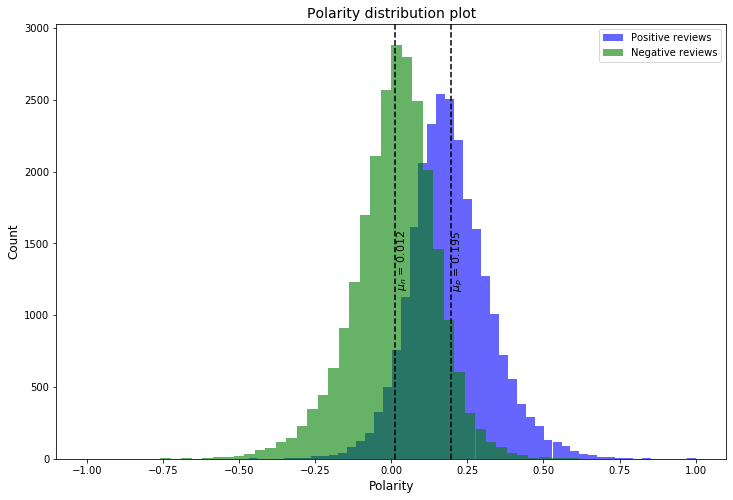

In [25]:
# Separate polarity score for positive and nagative reviews
pos_reviews_pol = dataset_feat.loc[dataset_feat.label==1, 'polarity']
neg_reviews_pol = dataset_feat.loc[dataset_feat.label==0, 'polarity']

# Create a new figure
plt.figure(figsize=(12,8))

# Create a histogram of polarity for positive reviews (color=blue, transparency=0.6)
plt.hist(pos_reviews_pol, bins=50, label='Positive reviews', alpha=0.6, color='blue')
# Create a histogram of polarity for negative reviews (color=green, transparency=0.6)
plt.hist(neg_reviews_pol, bins=50, label='Negative reviews', alpha=0.6, color='green')
# Create the title, horizontal axis label, vertical axis label and legend for the histograms
plt.title('Polarity distribution plot', size=14)
plt.xlabel('Polarity', size=12)
plt.ylabel('Count', size=12)
plt.legend(loc='upper right')

# Calculate the mean value of polarity for positive and negative reviews
pos_pol_mean = pos_reviews_pol.mean()
neg_pol_mean = neg_reviews_pol.mean()

# Add vertical lines that represent the average polarity of each class
plt.axvline(pos_pol_mean, c='k', linestyle='--', linewidth=1.5)
plt.axvline(neg_pol_mean, c='k', linestyle='--', linewidth=1.5)
# Add annotations
plt.text(pos_pol_mean, 1200, r'$\mu_p$ = {:.3f}'.format(pos_pol_mean), rotation=90, size=11)
plt.text(neg_pol_mean, 1200, r'$\mu_n$ = {:.3f}'.format(neg_pol_mean), rotation=90, size=11)

plt.show()

From the above plot, we can draw the following conclusions:
- Negative reviews mean polarity is greater than 0, which means that the *textblob* polarity function assigned the neutral sentiment (near zero) to most of the negative reviews.
- Positive reviews on the average have the sentiment near 0.2 which indicates that *textblob* properly calculated the polarity score for most of the reviews.
- Positive reviews polarity score is on the average greater than negative reviews sentiment score, which means that this measurement is able to contribute to increasing class separability.

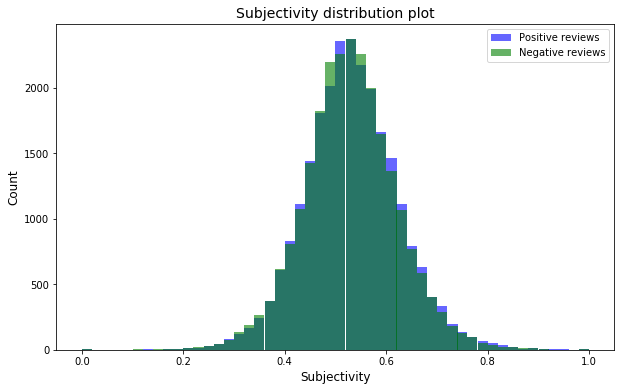

In [26]:
# Separate subjectivity score for positive and nagative reviews
pos_reviews_subj = dataset_feat.loc[dataset_feat.label==1, 'subjectivity']
neg_reviews_subj = dataset_feat.loc[dataset_feat.label==0, 'subjectivity']

# Create a new figure
plt.figure(figsize=(10,6))

# Create histograms of subjectivity for positive and negative reviews
plt.hist(pos_reviews_subj, bins=50, label='Positive reviews', alpha=0.6, color='blue')
plt.hist(neg_reviews_subj, bins=50, label='Negative reviews', alpha=0.6, color='green')
plt.title('Subjectivity distribution plot', size=14)
plt.xlabel('Subjectivity', size=12)
plt.ylabel('Count', size=12)
plt.legend(loc='upper right')

plt.show()

In contrast to the polarity distribution, on the subjectivity score plot, we can clearly see those distributions of positive and negative reviews overlap themselves. Subjectivity is on the average around the value of 0.5 for both types of reviews, which indicates that no matter what is the opinion given by the author, the reviews are in the same level objective/subjective. Subjectivity score feature likely will not contribute to the increase of model's classes predictive ability.

Next, the word count distributions for positive and negative reviews will be depicted.

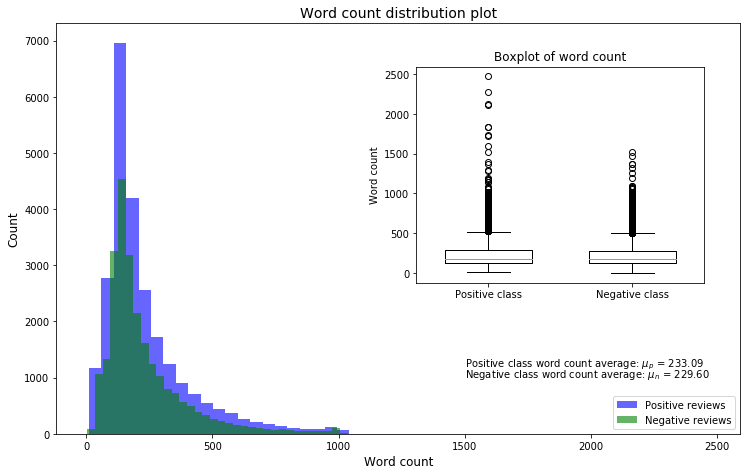

In [27]:
# Separate word count distributions for positive and nagative reviews 
# Violinplots or boxplots better deal with numpy arrays
pos_reviews_w_count = np.array(dataset_feat.loc[dataset_feat.label==1, 'word_count'])
neg_reviews_w_count = np.array(dataset_feat.loc[dataset_feat.label==0, 'word_count'])

# Create a new figure instance
fig = plt.figure(figsize=(10,6))

# Add axes to the figure. Create the first main window
ax1 = fig.add_axes([0, 0, 0.95, 0.95]) # window coord: (left, bottom, width, height)(in %)
ax1.hist(pos_reviews_w_count, bins=50, label='Positive reviews', alpha=0.6, color='blue')
ax1.hist(neg_reviews_w_count, bins=50, label='Negative reviews', alpha=0.6, color='green')
# Create the title, horizontal axis label, vertical axis label and legend for the histogram
ax1.set_title('Word count distribution plot', size=14)
ax1.set_xlabel('Word count', size=12)
ax1.set_ylabel('Count', size=12)
ax1.legend(loc='lower right')
# Add descriptions
ax1.text(1500, 1200, r'Positive class word count average: $\mu_p$ = {:.2f}'.format(pos_reviews_w_count.mean()))
ax1.text(1500, 1000, r'Negative class word count average: $\mu_n$ = {:.2f}'.format(neg_reviews_w_count.mean()))

# Add axes to the figure. Create the second boxplots window
ax2 = fig.add_axes([0.5, 0.35, 0.40, 0.50]) # window coord: (left, bottom, width, height)(in %)
# Create boxplots
ax2.boxplot([pos_reviews_w_count, neg_reviews_w_count], widths=0.6)
ax2.set_title('Boxplot of word count')
ax2.set_ylabel('Word count')
# Set the x axis labels
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Positive class', 'Negative class'])

plt.show()

From the above plot, we can draw the following conclusions:
- Boxplots of both classes show that the 25th percentile (Q1), median (Q2), 75th percentile (Q3) and the whiskers lengths (1.5 of IQR) are almost equal for positive and negative reviews.
- The mean values of word count for positive and negative classes are very similar to each other, and the distributions have the same shapes, which indicates that it might be hard for the model to distinguish between classes.
- The word count distributions for both classes are right-tailed, which means that the average value will be placed to the right of the median.
- Positive reviews tend to contain outliers in terms of the word count (extremely long opinions), while in negative reviews class this tendency is smaller.

The measures of the central tendency and variability plotted above can be also presented in a numerical form by using the *describe* method on the *pandas groupby* object.

In [31]:
dataset_feat.groupby(by='label').word_count.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,24698.0,229.596607,165.103430,4.0,128.0,174.0,278.0,1522.0
1,24884.0,233.090620,177.688169,10.0,125.0,172.0,284.0,2470.0


As we could see in the preceding plot, the above table also confirms that all the measures for positive and negative classes (except the maximum value) are very similar.

The next task will be to display the distributions of all the rest features at the one time.

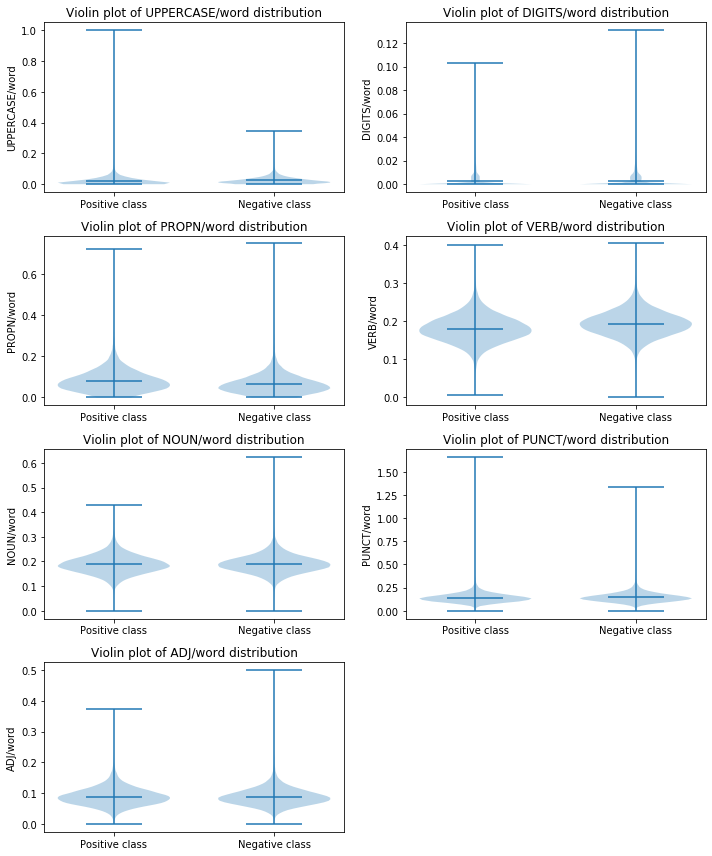

In [32]:
# Create the figure and axes instances
fig, axes = plt.subplots(4, 2, figsize=(10,12), sharex=False)
# Take the last 7 columns labels from the data frame
data_labels = dataset_feat.columns[-7:]
data_idx = 0

# Iterate through the plots rows and columns
for row in range(4):
    for col in range(2):
        if data_idx <= 6: 
            # Create the violinplot of given feature for positive and negative examples
            axes[row, col].violinplot([np.array(dataset_feat.loc[dataset_feat.label==1, data_labels[data_idx]]),
                                      np.array(dataset_feat.loc[dataset_feat.label==0, data_labels[data_idx]])],
                                      widths=0.7, showmeans=True)
            # Set the title and vertical axis labels
            axes[row, col].set_title('Violin plot of {}/word distribution'.format(data_labels[data_idx]))
            axes[row, col].set_ylabel('{}/word'.format(data_labels[data_idx]))
            # Set the x axis labels
            axes[row, col].set_xticks([1, 2])
            axes[row, col].set_xticklabels(['Positive class', 'Negative class'])
        else:
            # Delete unnecessary axes
            fig.delaxes(axes[row, col])
        data_idx += 1
        
# Automatically adjusts subplot params to fit in figure       
plt.tight_layout()

From the preceding plots, we can draw the following conclusions:
- The UPPERCASE to the word_count ratio on the average is the same for the positive and negative classes. Most of the reviews very rarely contain the uppercases. We can also see that one or few positive reviews were written using only the uppercase (feature value equals 1), while the maximum value of that feature for the negative class is around 0.4.
- The proportion of the number of DIGITS to the number of words is very small (near) zero for the positive and negative classes. These distributions only differ slightly in terms of the maximum values.
- The PROPN/word and VERB/word distributions are very similar for both classes as well.
- The distribution of the number of NOUNs to the number of words takes on the average the value of 0.2 for the negative and also for positive class. The maximum value for negative sentiment is slightly greater than for positive class.
- PUNCT/word distributions also are very similar in terms of the shape.
- Distributions of the ADJ/word feature for both classes are similar as well. They differ only in the maximum values.
- Based on the preceding conclusions we can say that all of our features presented above might contribute to the model's predictive ability in very small extent. Nevertheless, neural network is capable of finding dependencies even if they are hard to notice at first sight.

Now, we will depict the matrix of correlations between all the features to find out whether some of them are highly dependent on the others.

Plotting the correlation heatmap in the *seaborn* as presented below, with *matplotlib* in version 3.1.1 will truncate the top and bottom cells of the heatmap. This problem has been already reported, and likely will be tackled in the next version of *matplotlib* (3.3.2). Up to this time, the possible solutions to prevent cutting off the cells are the following:
- Downgrade the *matplotlib* to a prior version.
- Set y axis limit manually.

To visualize what is the class separability of all our features together we will perform dimensionality reduction to two dimensions using t-distributed Stochastic Neighbor Embedding algorithm.

TSNE belongs to manifold algorithms group. It converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. More information about manifolds can be found under the following link: https://scikit-learn.org/stable/modules/manifold.html

In [72]:
# Choose at random a sample of 10,000 examples to visualize
data_to_vis = dataset_feat.iloc[:, -11:].sample(n=10000)
feat_to_vis = data_to_vis.iloc[:, -10:]
label_to_vis = data_to_vis.iloc[:, 0]

# Perform MinMax feature scaling
feat_to_vis = MinMaxScaler().fit_transform(feat_to_vis)

# Perform dimensionality reduction using t-SNE
emb_vectors = TSNE(n_components=2, n_iter=1000).fit_transform(feat_to_vis)

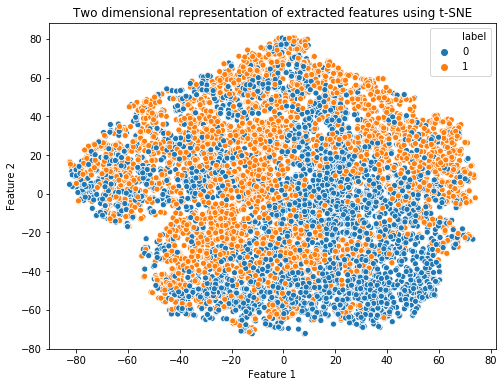

In [90]:
# Visualize data in lower-dimensional space
plt.figure(figsize=(8,6))
# Create seaborn scatterplot
sns.scatterplot(x=emb_vectors[:, 0], y=emb_vectors[:, 1], hue=label_to_vis)
plt.title('Two dimensional representation of extracted features using t-SNE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

We can see in the preceding plot that t-SNE algorithm successfully reduced the dimensionality of all our features. Embedded representation of the features can be thought of as having moderate class separability - most of the positive examples are located in the left and upper part of the plot, thus it is possible to use this representation as an additional feature to increase models performance.

Because t-SNE is very computationally expensive, it is worth to check other algorithms dimensionality reduction results. Below we will use the kernel Principal Component Analysis with 'rbf' kernel, that will perform the dimensionality reduction task faster.

In [88]:
# Perform dimensionality reduction using kernel PCA
emb_vectorsPCA = KernelPCA(n_components=2, kernel='rbf').fit_transform(feat_to_vis)

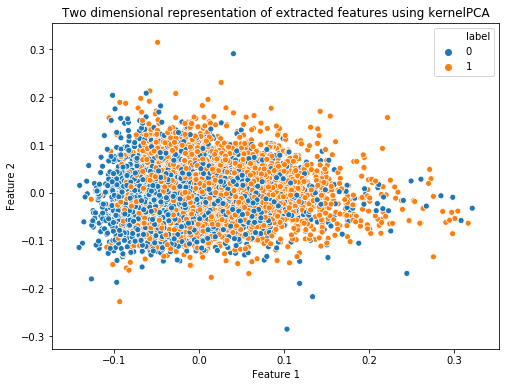

In [91]:
# Visualize data in lower-dimensional space
plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_vectorsPCA[:, 0], y=emb_vectorsPCA[:, 1], hue=label_to_vis)
plt.title('Two dimensional representation of extracted features using kernelPCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

As we can see in the above plot the class separability is not very good as well, but it is possible to fit here a decision boundary that will separate classes with some accuracy.

Now, we will depict the matrix of correlations between all the features to find out whether some of them are highly dependent on the others.

Plotting the correlation heatmap in the *seaborn* as presented below, with *matplotlib* in version 3.1.1 will truncate the top and bottom cells of the heatmap. This problem has been already reported, and likely will be tackled in the next version of *matplotlib* (3.3.2). Up to this time, the possible solutions to prevent cutting off the cells are the following:
- Downgrade the *matplotlib* to a prior version.
- Set y axis limit manually.

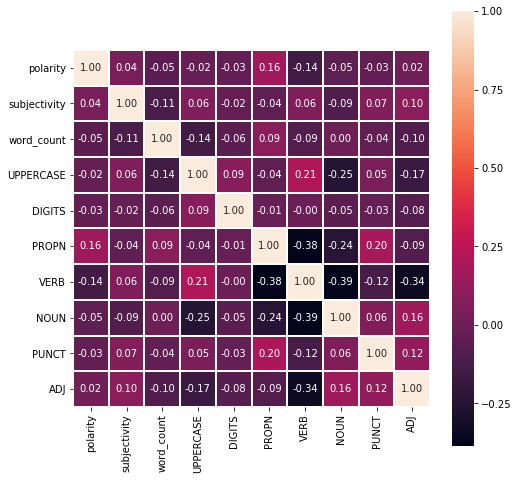

In [34]:
# Calculate correlations between the features
corr_matrix = dataset_feat.iloc[:, 2:].corr()

# Plot correlation matrix
plt.figure(figsize=(8,8))
ax = sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=1, square=True)
# Set limit of y axis. To check current settings use: ax.get_ylim()
ax.set_ylim(10,0)
plt.show()

The closer the correlation coefficient is to 1 the more the variables are positively correlated, the value of 0 indicates that there is none relationship between variables, while the closer to -1 the more they are negatively correlated.

On the above matrix, we can notice that most of the variables are not related to each other. The values of the correlation coefficient near -0.4 take only the following pairs: VERB/PROPN, NOUN/VERB, ADJ/VERB which means that if the first feature increase, there is a possibility that the second related feature will decrease. It is important to use in ML algorithms only features that are not highly correlated.

### Text preprocessing

In this section, we are going to perform text preprocessing. The main objective of this process is to bring the text into the analyzable format. The implications of this operation are the following: the string length is reduced, the number of unique words is diminished, we also deal with sparsity issue, and standardize the vocabulary. This is very important from the neural network point of view, because, it should make the text more interpretable and increase the accuracy for text classification.

In [2]:
# Import the dataset
dataset_feat = pd.read_csv('dataset/datasets_feat/dataset_feat.csv')

Below we are going to define the function that will preprocess the text using the following methods:
- Removing HTML tags.
- Making all text lowercase.
- Removing stopwords (examples: 'the', 'at, 'is, 'which')
- Removing whitespaces.
- Removing punctuations.
- Removing digits.
- Lemmatization (remove inflections and map a word to its root form).

In [50]:
def token_filter(token):
    """Filter the token for text_preprocessing function.
    Check if the token is not: punctuation, whitespace, stopword or digit.
    
    Parameters
    ----------
    token : spacy.Token
        Token passed from text_preprocessing function.

    Returns
    -------
    Bool
       True if token meets the criteria, otherwise False.
        
    """
    return not (token.is_punct | token.is_space | token.is_stop | token.is_digit | token.like_num)

def text_preprocessing(df, batch_size, n_threads):
    """Perform text preprocessing using the following methods: removing HTML tags, lowercasing, 
    lemmatization and removing stopwords, whitespaces, punctuations, digits. 

    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
        
    Returns
    -------
    pandas.Series
       Pandas.Series containing processed strings.
        
    """
    # Remove HTML tags
    df = df.apply(remove_tags)
    # Make lowercase
    df = df.str.lower()
    processed_docs = []
    for doc in list(nlp.pipe(df, batch_size=batch_size, n_threads=n_threads)):
        # Remove stopwords, spaces, punctutations and digits
        text = [token for token in doc if token_filter(token)]
        # Lemmatization
        text = [token.lemma_ for token in text if token.lemma_ != '-PRON-']
        processed_docs.append(' '.join(text))
    return pd.Series(processed_docs, name='clean_review', index=df.index) 

After defining the function, we will test its processing time and fine-tune the batch_size and n_threads hyperparameters.

In [6]:
# Define the variables
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', 'tagger', '...'])
batch_size = 512
n_threads = 2

# Test the processing time on a part of the trainig set, given batch_size and n_threads
print('Start processing 1000 examples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
start_time = timeit.default_timer()
text_preprocessing(dataset_feat.loc[:1000, 'review'], batch_size=batch_size, n_threads=n_threads)
print('Processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 1000 examples using batch_size: 512 and n_threads: 2
Processing time: 5.26 sec


Similarly to how we have tackled the problem with high memory usage while feature engineering was performed, now we will divide the document into smaller chunks as well, to process them separately, then after each part is processed, the language model will be reloaded. After going through entire dataset we will merge all the chunks back together, and export dataset with normalized text to CSV file.

In [10]:
def split_norm_save(df, name, path, part_size, batch_size, n_threads, nlp):
    """Split data frame into chunks of size equal: part_size and perform text preprocessing on each of the parts.
    Preprocess strings using the following methods: removing HTML tags, lowercasing, lemmatization and 
    removing stopwords, whitespaces, punctuations, digits. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas.DataFrame containing 'review' column to preprocess.
    name : str
        Name of the CSV file to which export the data. 
    path : str
        Absolute or relative path to directory where to save the data. 
    part_size: int
        Size of the chunk to process (number of strings it contains).
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
    nlp: spacy.lang.<language>
        Spacy language model (for example spacy.lang.en.English)
        
    Returns
    -------
    pandas.DataFrame
       Concatenation of the original data frame and pandas series of normalized strings.
        
    """
    if name not in os.listdir(path):
        dataset_parts = []
        N = int(len(df)/part_size)
        # Create list of dataframe chunks
        data_frames = [df.iloc[i*part_size:(i+1)*part_size, 0].copy() for i in range(N+1)]
        # Process dataset partialy 
        for frame in tqdm_notebook(data_frames):
            # Normalize dataset chunk
            dataset_part = text_preprocessing(frame, batch_size=batch_size, n_threads=n_threads)
            dataset_parts.append(dataset_part)
            # Reload nlp
            nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', '...'])

        # Concatenate all parts into one series
        concat_clean = pd.concat(dataset_parts, axis=0, sort=False)
        # Concatenate dataset and cleaned review seires
        dataset_clean = pd.concat([df, concat_clean], axis=1)        
        # Export data frame to CSV file
        dataset_clean.to_csv(path + name, index=False)
    else:
        print('File {} already exists in given directory.'.format(name)) 

In [53]:
# Define variables
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', 'tagger', '...'])
batch_size = 512
n_threads = 2
part_size = 5000
path = os.path.join(os.getcwd(), 'dataset/datasets_feat_clean/')
name = 'dataset_feat_clean.csv'

# Perform text preprocessing and save the resulted frame to CSV file
split_norm_save(dataset_feat, name, path, part_size, batch_size, n_threads, nlp)

File dataset_feat_clean.csv already exists in given directory.


### Visualize cleaned reviews

Now that we have preprocessed the text we are going to visualize the effects of that operation.

In [2]:
# Import preprocessed dataset from CSV file
dataset_feat_clean = pd.read_csv('dataset/datasets_feat_clean/dataset_feat_clean.csv')

In [3]:
# Display the first 5 rows
dataset_feat_clean.head()

,review,label,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,clean_review
0,Bromwell High is a cartoon comedy. It ran at t...,1,0.0867,0.4680,140,0.050000,0.00714,0.0643,0.1571,0.2142,0.1643,0.07855,bromwell high cartoon comedy run time program ...
1,Homelessness (or Houselessness as George Carli...,1,0.0977,0.4316,428,0.002337,0.00000,0.1028,0.2056,0.1846,0.1145,0.05374,homelessness houselessness george carlin state...
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,0.2104,0.5557,147,0.013600,0.00000,0.0748,0.1700,0.2380,0.1837,0.11566,brilliant act lesley ann warren well dramatic ...
3,This is easily the most underrated film inn th...,1,0.2279,0.5674,124,0.024200,0.00000,0.0968,0.1290,0.1774,0.1613,0.09680,easily underrate film inn brook cannon sure fl...
4,This is not the typical Mel Brooks film. It wa...,1,0.2534,0.3690,120,0.000000,0.00000,0.0750,0.2084,0.1417,0.1583,0.08330,typical mel brook film slapstick movie actuall...


In [56]:
# Display the random review before normalization
idx = np.random.randint(dataset_feat_clean.shape[0])
HTML(dataset_feat_clean.loc[idx, 'review'])

In [57]:
# Display normalized review
HTML(dataset_feat_clean.loc[idx, 'clean_review'])

REVIEW END.
<br>
<br>
As we can see above the processed review is much shorter, it consists of the only root of the words, doesn't have any punctuations, stopwords, digits or HTML tags, and the entire string is lowercased.

Now we are going to visualize most occurred words in both types of reviews using a tool called Scattertext. To make computation faster we will use 1500 examples from each of the class.

For more information about this tool, visit the following link:
https://github.com/JasonKessler/scattertext#visualizing-term-associations

In [58]:
# Load the language model
nlp = spacy.load('en_core_web_sm')

# Create the data frame that contains positive and neagtive reviews to visualize
pos_to_visual = dataset_feat_clean.loc[dataset_feat_clean.label==1, ['clean_review', 'label']].head(1500).copy()
neg_to_visual = dataset_feat_clean.loc[dataset_feat_clean.label==0, ['clean_review', 'label']].head(1500).copy()
data_to_visual = pd.concat([pos_to_visual, neg_to_visual], axis=0)
# Replace numerical labels by strings (required by scattertext)
data_to_visual.label = data_to_visual.label.replace([1,0], ['pos', 'neg'])

In [59]:
# Create the Scattertext corpus
corpus = st.CorpusFromPandas(data_to_visual,
                             category_col='label',
                             text_col='clean_review',
                             nlp=nlp).build()

In [60]:
# Create the scattertext plot
html = st.produce_scattertext_explorer(corpus,
          category='pos',
          category_name='Positive reviews',
          not_category_name='Negative reviews',
          width_in_pixels=600,
          height_in_pixels=500)
# Save the visualization as HTML file
open('assets/scattertext_visualization.html', 'wb').write(html.encode('utf-8'))

3940231

In [61]:
# Depict word visualization (it may take a while to load)
IFrame(src='assets/scattertext_visualization.html', width = 800, height=700)

What we can see on the Scattertext plot is for example, the top occurred words in both types of reviews. For the positive class, we can distinguish here words like 'tarzan', 'excellent', 'perfect' or 'wonderful'. The three last words aren't a surprise, but the word 'tarzan' appears probably because the dataset consists of many Tarzan movie reviews, which mostly are positive, and their authors used the term 'tarzan' frequently. In the negative reviews class, we can find words like 'waste', 'awfull', 'bore', or 'poor'.

Another way to represent text data in the visual form may be to use the Word Clouds, which use font size to show the importance of each word.

In [62]:
# Separate positive and negative reviews and then concatenate all reviews within given group
pos_reviews = ' '.join(data_to_visual.loc[data_to_visual.label=='pos', 'clean_review'])
neg_reviews = ' '.join(data_to_visual.loc[data_to_visual.label=='neg', 'clean_review'])

In [63]:
# Create wordcloud for positive reviews
wordcloud_pos = WordCloud(background_color='black',
                      width=600,
                      height=500).generate(pos_reviews)

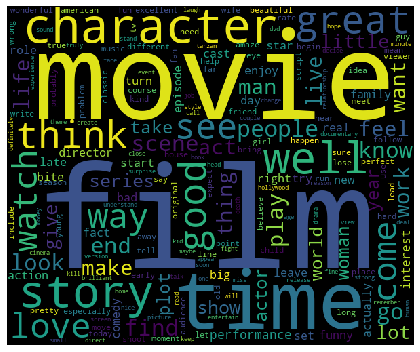

In [64]:
# Depict wordcloud for positive reviews
plt.figure(figsize=(8,5))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.tight_layout()

In [65]:
# Create wordcloud for negative reviews
wordcloud_neg = WordCloud(background_color='black',
                      width=600,
                      height=500).generate(neg_reviews)

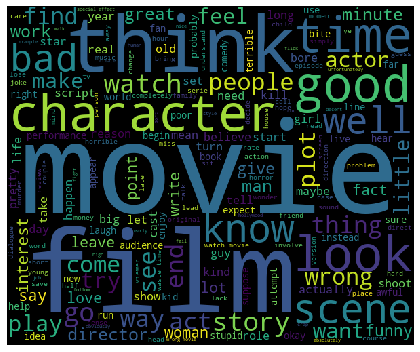

In [66]:
# Depict wordcloud for negative reviews
plt.figure(figsize=(8,5))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.tight_layout()

According to word clouds the most important words in the positive class are: 'film', 'movie', 'character, 'time' or 'think'. For negative class, the most relevant words are almost the same as for positive reviews. Classes differ only in terms of words with lower font size such as 'bad', 'wrong' for negative reviews or 'love' for positive opinions.

### Preparing training, validaton and test sets

The dataset is well prepared, so the next thing will be to split it into the training, validation and test sets.

In [5]:
def train_val_test_split(df, val_size, test_size, random_state=0):
    """Split data frame into 3 (train/val/test) sets or into 2 (train/val) sets.
    
    If you want to split into two datasets, set test_size = 0.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas.DataFrame to split.
    val_size : float
        Fraction of dataset to include in validation set. Should be from range (0.0, 1.0).
    test_size : float
        Fraction of dataset to include in test set. Should be from range <0.0, 1.0).
    random_state: int, optional (default=0)
        The seed used by the random number generator.
    
    Returns
    -------
    train: pandas.DataFrame
       Training set.
    val: pandas.DataFrame
       Validation set.   
    test: pandas.DataFrame
       Test set.
    
    Raises
    ------
    AssertionError 
        If the val_size and test_size sum is greater or equal 1 or the negative value was passed.
    
    """
    assert (val_size + test_size) < 1, 'Validation size and test size sum is greater or equal 1'
    assert val_size >= 0 and test_size >= 0, 'Negative size is not accepted'
    train, val, test = np.split(df.sample(frac=1, random_state=random_state),
                                [int((1-(val_size+test_size))*len(df)), int((1-test_size)*len(df))])
    return train, val, test

In [6]:
# Split entire raw dataset into training, validation and test sets
train_set, val_set, test_set = train_val_test_split(dataset_feat_clean, val_size=0.20, test_size=0.10)

In [7]:
# Check training, validation and test sets shapes
print('Training set shape: {}'.format(train_set.shape))
print('Validation set shape: {}'.format(val_set.shape))
print('Test set shape: {}'.format(test_set.shape))

Training set shape: (34707, 13)
Validation set shape: (9916, 13)
Test set shape: (4959, 13)


In [8]:
# Save training, validation and test sets to CSV files
train_set.to_csv('dataset/datasets_feat_clean/train_feat_clean.csv', index=False)
val_set.to_csv('dataset/datasets_feat_clean/val_feat_clean.csv', index=False)
test_set.to_csv('dataset/datasets_feat_clean/test_feat_clean.csv', index=False)

In the next notebook we are going to build a vocabulary.